# Building a Custom MLP Estimator for MNIST

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np

import tensorflow as tf

/home/samwit/anaconda3/envs/tf140-gpu/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
print(tf.__version__)

1.4.0


## Dataset

In [3]:
# We'll use Keras (included with TensorFlow) to import the data
# I figured I'd do all the preprocessing and reshaping here, 
# rather than in the model.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train_int = y_train.astype('int32')
y_test_int = y_test.astype('int32')

# Normalize the color values to 0-1
# (as imported, they're 0-255)
x_train /= 255
x_test /= 255

# Flatten 28x28 images to (784,)
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# Convert to one-hot.
y_train = tf.keras.utils.to_categorical(y_train_int, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test_int, num_classes=10)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
# Set up a ploting function 

fig_size = [10,10]
plt.rcParams["figure.figsize"] = fig_size

def plot_images(images, labels_true, preds=None):

    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28,28), cmap='binary')

        # True vs predicted labels
        if preds is None:
            xlabel = "True: {0}".format(labels_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(labels_true[i], preds[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Draw the plot
    plt.show()

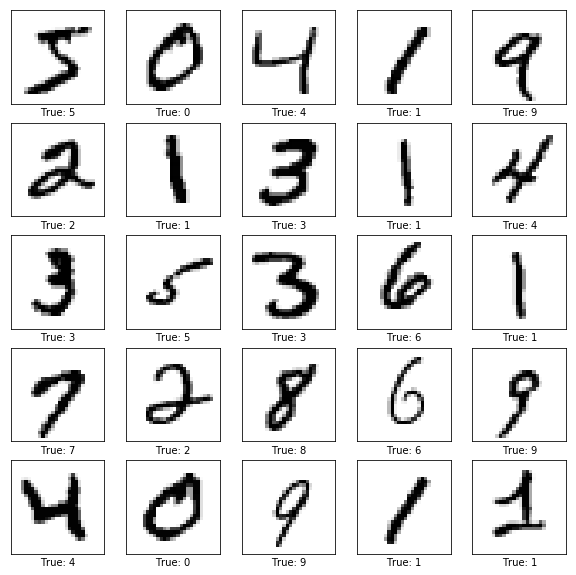

In [5]:
plot_images(x_train[:25],y_train_int[:25])

### Model details

In [6]:
# Number of neurons in each hidden layer
HIDDEN1_SIZE = 256
HIDDEN2_SIZE = 100
LEARNING_RATE = 0.004


In [7]:
def model_fn(features, labels, mode):
    
    # We use tf.layers to create 2 fully connected layers
    fc1 = tf.layers.dense(features['x'], HIDDEN1_SIZE, activation=tf.nn.relu, name="fc1")
    fc2 = tf.layers.dense(fc1, HIDDEN2_SIZE, activation=tf.nn.relu, name="fc2")
    
    # We add some dropout after the 2 layers (10% dropout only on traiing layer)
    dropout = tf.layers.dropout(inputs=fc2, rate=0.1, training = mode == tf.estimator.ModeKeys.TRAIN, name="dropout")

    # The logits layer
    logits = tf.layers.dense(dropout, units=10, name="logits")
    
    # Generate Predictions for returning to 
    classes = tf.argmax(logits, axis=1)
    predictions = {
        'classes': classes,
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    
    # If its .predict return this
    if mode == tf.estimator.ModeKeys.PREDICT:
        # Return an EstimatorSpec for prediction
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
        
    # Calculate the loss using cross entropy with a softmax on the logits
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)
        
    if mode == tf.estimator.ModeKeys.TRAIN:
        
        # Configure the Training Op
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=LEARNING_RATE,
            optimizer='Adam')

        # Return an EstimatorSpec for training
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, loss=loss, train_op=train_op)    

    assert mode == tf.estimator.ModeKeys.EVAL
    
    # Configure the accuracy metric for evaluation
    metrics = {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, axis=1))}
    
    return tf.estimator.EstimatorSpec(mode=mode, 
                                      predictions=predictions, 
                                      loss=loss,
                                      eval_metric_ops=metrics)

In [8]:
# Define the input functions
train_input = tf.estimator.inputs.numpy_input_fn(
    {'x': x_train},
    y_train, 
    num_epochs=None, # repeat forever
    shuffle=True # 
)

test_input = tf.estimator.inputs.numpy_input_fn(
    {'x': x_test},
    y_test,
    num_epochs=1, # loop through the dataset once
    shuffle=False # don't shuffle the test data
)

## Build the Estimator

In [9]:
# At this point, our Estimator will work just like a canned one.
estimator = tf.estimator.Estimator(model_fn=model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpujzi2az1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f15308f5630>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train the model

In [10]:
# Train the estimator using our input function.
estimator.train(input_fn=train_input, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpujzi2az1/model.ckpt.
INFO:tensorflow:loss = 2.37841, step = 1
INFO:tensorflow:global_step/sec: 720.445
INFO:tensorflow:loss = 0.296042, step = 101 (0.139 sec)
INFO:tensorflow:global_step/sec: 852.567
INFO:tensorflow:loss = 0.20824, step = 201 (0.117 sec)
INFO:tensorflow:global_step/sec: 820.004
INFO:tensorflow:loss = 0.140725, step = 301 (0.122 sec)
INFO:tensorflow:global_step/sec: 858.574
INFO:tensorflow:loss = 0.197077, step = 401 (0.116 sec)
INFO:tensorflow:global_step/sec: 853.517
INFO:tensorflow:loss = 0.0995349, step = 501 (0.117 sec)
INFO:tensorflow:global_step/sec: 823.672
INFO:tensorflow:loss = 0.0946015, step = 601 (0.121 sec)
INFO:tensorflow:global_step/sec: 850.268
INFO:tensorflow:loss = 0.108348, step = 701 (0.118 sec)
INFO:tensorflow:global_step/sec: 847.012
INFO:tensorflow:loss = 0.105045, step = 801 (0.119 sec)
INFO:tensorflow:global_step/sec: 855.526
INFO:tensorflow:loss =

## Evaluate the Model

In [11]:
# Evaluate the estimator using the test data that the model hasn't seen
estimator.evaluate(input_fn=test_input)


INFO:tensorflow:Starting evaluation at 2017-11-21-03:15:31
INFO:tensorflow:Restoring parameters from /tmp/tmpujzi2az1/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-11-21-03:15:31
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9793, global_step = 2000, loss = 0.0661808


{'accuracy': 0.97930002, 'global_step': 2000, 'loss': 0.066180833}

## Make some indvidual preditions

In [12]:
number_to_show = 10

# This returns a generator object
predictions = estimator.predict(input_fn=test_input)

# we get the prdictions into a list
preds = [pred['classes'] for pred in predictions]

for i in range(number_to_show):
    true_label = y_test_int[i]
    pred = preds[i]
    print("Example %d. True: %d, Predicted: %d" % (i, true_label, pred))


INFO:tensorflow:Restoring parameters from /tmp/tmpujzi2az1/model.ckpt-2000
Example 0. True: 7, Predicted: 7
Example 1. True: 2, Predicted: 2
Example 2. True: 1, Predicted: 1
Example 3. True: 0, Predicted: 0
Example 4. True: 4, Predicted: 4
Example 5. True: 1, Predicted: 1
Example 6. True: 4, Predicted: 4
Example 7. True: 9, Predicted: 9
Example 8. True: 5, Predicted: 5
Example 9. True: 9, Predicted: 9


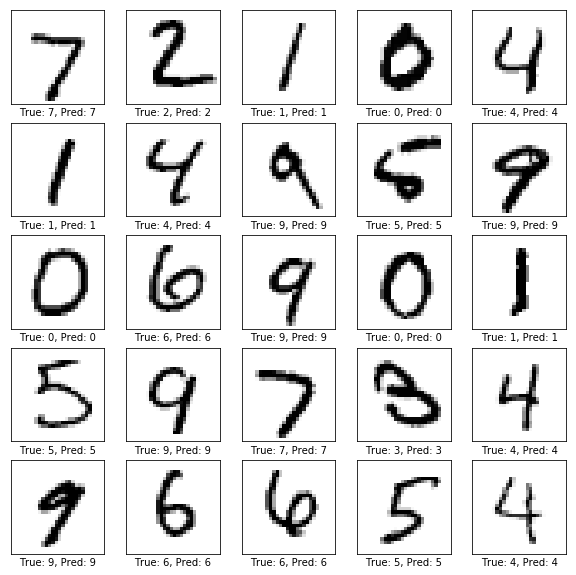

In [13]:
plot_images(x_test[:25],y_test_int[:25],preds[:25])

## What did the model get wrong?

In [14]:
wrong_x = []
wrong_pred = []
wrong_y = []

for i in range(len(preds)):
    if y_test_int[i] != preds[i]:
        wrong_x.append(x_test[i])
        wrong_pred.append(preds[i])
        wrong_y.append(y_test_int[i])

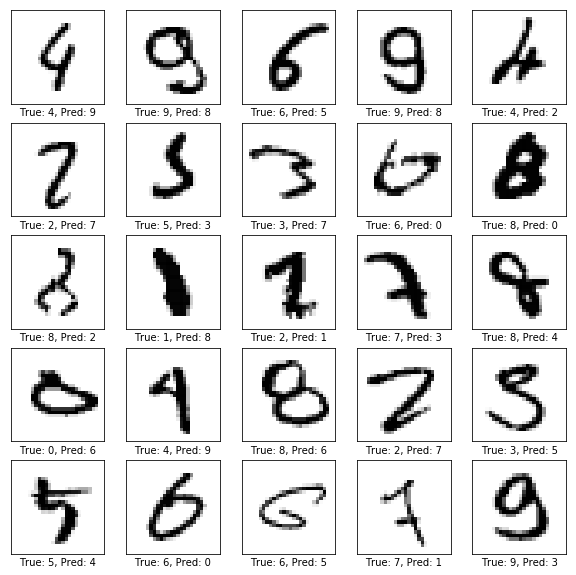

In [15]:
plot_images(wrong_x[:25],wrong_y[:25],wrong_pred[:25])